# EEG Classification using CNN+LSTM model

In [107]:
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, ProgbarLogger, BaseLogger
from keras import backend as K
from keras.regularizers import l1_l2

import data as dt

In [4]:
reload(dt)

<module 'data' from 'data.py'>

In [2]:
path_to_data = 'C:/Users/alena/Desktop/homed/laba/data/rawData' #'/home/moskaleona/alenadir/data/rawData' 

In [3]:
data = dt.DataBuildClassifier(path_to_data).get_data([25, 33], shuffle=True, random_state=1, resample_to=128, windows=[(0.2, 0.5)],baseline_window=(0.2, 0.3))

In [4]:
print('Percentage of target class: %f %%'%(data[33][1].mean()*100))
print('Percentage of target class: %f %%'%(data[25][1].mean()*100))

Percentage of target class: 64.027539 %
Percentage of target class: 71.732523 %


In [6]:
print (data[33][0].shape)
print (data[33][1].shape)

(581, 39, 19)
(581,)


In [67]:
from sklearn.metrics import roc_auc_score
import logging

class LossMetricHistory(Callback):
    def __init__(self, validation_data=(), verbose=1):
        super(LossMetricHistory, self).__init__()
        self.x_val, self.y_val = validation_data
        self.verbose = verbose
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.INFO)
        console = logging.StreamHandler()
        console.setLevel(logging.INFO)
        formatter = logging.Formatter("%(message)s")
        console.setFormatter(formatter)
        if len(self.logger.handlers) > 0:
            self.logger.handlers = []
        self.logger.addHandler(console)
            
    
    def on_train_begin(self, logs={}):
        self.logger.info("Training began")
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []
        self.aucs = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        
        self.y_pred = self.model.predict_proba(self.x_val, verbose=0)
        self.aucs.append(roc_auc_score(self.y_val, self.y_pred))
        self.logger.info("epoch %d results: train loss = %.6f, val loss = %.6f"%(epoch + 1, self.losses[-1], self.val_losses[-1]) + 
                     "\n\t\t\tacc = %.6f, val acc = %.6f"%(self.accs[-1], self.val_accs[-1]) +
                     "\n\t\t\tauc = %.6f"%(self.aucs[-1]))
        

In [105]:
from sklearn.metrics import roc_auc_score, accuracy_score
class CnnLstmClassifier():
    def __init__(self, loss='binary_crossentropy', n_filters=10, n_lstm=30):
        self.loss = loss
        self.n_lstm = n_lstm
        self.n_filters = n_filters
    
    def _make_test_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Dense(1, input_shape=(741,), activation='sigmoid'))
        
    def _make_model(self, input_shape, dropout, dropout_lstm, recurrent_dropout):
        batch_input_shape = (None, input_shape[1], input_shape[2])
        self.model = Sequential()
        self.model.add(Conv1D(self.n_filters, self.kernel_size, batch_input_shape=batch_input_shape,
                         activation='relu', kernel_regularizer=l1_l2(self.l1, self.l2)))
        self.model.add(Dropout(dropout))
        self.model.add(LSTM(self.n_lstm,
                       dropout=dropout_lstm, recurrent_dropout=recurrent_dropout))
        self.model.add(Dense(1, activation='sigmoid'))
    
    def train(self, X_train, y_train, X_val=None, y_val=None, n_epochs=5, batch_size=10, n_iter=5, learning_rate=0.001,
              l1=0., l2=0.0, dropout=0., dropout_lstm=0., recurrent_dropout=0., verbose=1):
        self.learning_rate = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.kernel_size = X_train.shape[2]
        #self._make_test_model(X_train.shape)
        self._make_model(X_train.shape, dropout, dropout_lstm, recurrent_dropout)
        self.optimizer = RMSprop(lr=learning_rate)
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['acc'])

        self.log = LossMetricHistory(validation_data=(X_val, y_val))#BaseLogger()
        self.hist = self.model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=n_epochs, 
                        validation_data=(X_val, y_val), verbose=verbose, callbacks=[self.log])
        return self.hist
    
    def predict(self, X, threshold=0.5):
        proba = self.model.predict(X)
        return (proba > threshold).astype('int32')
    
    def predict_proba(self, X):
        return self.model.predict(X)
    
    
    def score(self, X, y, metrics='auc'):
        try:
            if metrics=='auc':
                return roc_auc_score(self.predict_proba(X), y)
            elif metrics=='acc':
                return accuracy_score(self.predict(X), y)
            else:
                raise ValueError(message="No such option: '%s'. Use 'auc' or 'acc'"%str(metrics))
        except ValueError as err:
            print(err)
    

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data[33][0], data[33][1], test_size=0.2, stratify=data[33][1], random_state=108)

In [110]:
clf = CnnLstmClassifier(n_lstm=30, n_filters=10)
#clf.train(data[33][0][:3,...].flatten().reshape(3, -1), data[33][1][:3,], data[33][0][4:7,...].flatten().reshape(3, -1), data[33][1][4:7,], n_epochs=5)
clf.train(X_train, y_train, X_val, y_val, n_epochs=100)

Training began


Train on 464 samples, validate on 117 samples
Epoch 1/100
464/464 [==============================] - 8s 16ms/step - loss: 0.6942 - acc: 0.5453 - val_loss: 0.6696 - val_acc: 0.5897


epoch 1 results: train loss = 0.694217, val loss = 0.669568
			acc = 0.545259, val acc = 0.589744
			auc = 0.487619


Epoch 2/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6333 - acc: 0.6336 - val_loss: 0.7015 - val_acc: 0.5726


epoch 2 results: train loss = 0.633310, val loss = 0.701545
			acc = 0.633621, val acc = 0.572650
			auc = 0.436190


Epoch 3/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6324 - acc: 0.6379 - val_loss: 0.6937 - val_acc: 0.5641


epoch 3 results: train loss = 0.632371, val loss = 0.693657
			acc = 0.637931, val acc = 0.564103
			auc = 0.486349


Epoch 4/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6224 - acc: 0.6530 - val_loss: 0.6921 - val_acc: 0.5556


epoch 4 results: train loss = 0.622421, val loss = 0.692130
			acc = 0.653017, val acc = 0.555556
			auc = 0.471746


Epoch 5/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6011 - acc: 0.6638 - val_loss: 0.6725 - val_acc: 0.5983


epoch 5 results: train loss = 0.601120, val loss = 0.672499
			acc = 0.663793, val acc = 0.598291
			auc = 0.523175


Epoch 6/100
464/464 [==============================] - 2s 3ms/step - loss: 0.5962 - acc: 0.6746 - val_loss: 0.6640 - val_acc: 0.5897


epoch 6 results: train loss = 0.596237, val loss = 0.663980
			acc = 0.674569, val acc = 0.589744
			auc = 0.547619


Epoch 7/100
464/464 [==============================] - 2s 3ms/step - loss: 0.5804 - acc: 0.6983 - val_loss: 0.6743 - val_acc: 0.6068


epoch 7 results: train loss = 0.580355, val loss = 0.674294
			acc = 0.698276, val acc = 0.606838
			auc = 0.527302


Epoch 8/100
464/464 [==============================] - 2s 3ms/step - loss: 0.5623 - acc: 0.7177 - val_loss: 0.6954 - val_acc: 0.5983


epoch 8 results: train loss = 0.562349, val loss = 0.695449
			acc = 0.717672, val acc = 0.598291
			auc = 0.487937


Epoch 9/100
464/464 [==============================] - 2s 3ms/step - loss: 0.5479 - acc: 0.7263 - val_loss: 0.6857 - val_acc: 0.5983


epoch 9 results: train loss = 0.547859, val loss = 0.685698
			acc = 0.726293, val acc = 0.598291
			auc = 0.506032


Epoch 10/100
464/464 [==============================] - 2s 3ms/step - loss: 0.5268 - acc: 0.7543 - val_loss: 0.7018 - val_acc: 0.6239


epoch 10 results: train loss = 0.526828, val loss = 0.701779
			acc = 0.754310, val acc = 0.623932
			auc = 0.504762


Epoch 11/100
464/464 [==============================] - 2s 3ms/step - loss: 0.5206 - acc: 0.7694 - val_loss: 0.7141 - val_acc: 0.5812


epoch 11 results: train loss = 0.520598, val loss = 0.714080
			acc = 0.769397, val acc = 0.581197
			auc = 0.488889


Epoch 12/100
464/464 [==============================] - 2s 3ms/step - loss: 0.5000 - acc: 0.7823 - val_loss: 0.6971 - val_acc: 0.5897


epoch 12 results: train loss = 0.500024, val loss = 0.697129
			acc = 0.782328, val acc = 0.589744
			auc = 0.533333


Epoch 13/100
464/464 [==============================] - 2s 4ms/step - loss: 0.4935 - acc: 0.7672 - val_loss: 0.6927 - val_acc: 0.5726


epoch 13 results: train loss = 0.493543, val loss = 0.692749
			acc = 0.767241, val acc = 0.572650
			auc = 0.521270


Epoch 14/100
464/464 [==============================] - 2s 4ms/step - loss: 0.4760 - acc: 0.7888 - val_loss: 0.7367 - val_acc: 0.5299


epoch 14 results: train loss = 0.476022, val loss = 0.736724
			acc = 0.788793, val acc = 0.529915
			auc = 0.500000


Epoch 15/100
464/464 [==============================] - 2s 3ms/step - loss: 0.4626 - acc: 0.7974 - val_loss: 0.7487 - val_acc: 0.5470


epoch 15 results: train loss = 0.462573, val loss = 0.748693
			acc = 0.797414, val acc = 0.547009
			auc = 0.488571


Epoch 16/100
464/464 [==============================] - 2s 3ms/step - loss: 0.4526 - acc: 0.8082 - val_loss: 0.7543 - val_acc: 0.5299


epoch 16 results: train loss = 0.452582, val loss = 0.754349
			acc = 0.808190, val acc = 0.529915
			auc = 0.478413


Epoch 17/100
464/464 [==============================] - 2s 4ms/step - loss: 0.4328 - acc: 0.8190 - val_loss: 0.7773 - val_acc: 0.5556


epoch 17 results: train loss = 0.432781, val loss = 0.777251
			acc = 0.818966, val acc = 0.555556
			auc = 0.481587


Epoch 18/100
464/464 [==============================] - 2s 4ms/step - loss: 0.4175 - acc: 0.8254 - val_loss: 0.7378 - val_acc: 0.5470


epoch 18 results: train loss = 0.417483, val loss = 0.737801
			acc = 0.825431, val acc = 0.547009
			auc = 0.533016


Epoch 19/100
464/464 [==============================] - 2s 4ms/step - loss: 0.4038 - acc: 0.8276 - val_loss: 0.7440 - val_acc: 0.5726


epoch 19 results: train loss = 0.403818, val loss = 0.744048
			acc = 0.827586, val acc = 0.572650
			auc = 0.515873


Epoch 20/100
464/464 [==============================] - 2s 3ms/step - loss: 0.3797 - acc: 0.8513 - val_loss: 0.7885 - val_acc: 0.5897


epoch 20 results: train loss = 0.379719, val loss = 0.788463
			acc = 0.851293, val acc = 0.589744
			auc = 0.530159


Epoch 21/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3734 - acc: 0.8556 - val_loss: 0.7910 - val_acc: 0.5470


epoch 21 results: train loss = 0.373419, val loss = 0.791045
			acc = 0.855603, val acc = 0.547009
			auc = 0.518730


Epoch 22/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3834 - acc: 0.8341 - val_loss: 0.7773 - val_acc: 0.5470


epoch 22 results: train loss = 0.383369, val loss = 0.777259
			acc = 0.834052, val acc = 0.547009
			auc = 0.524762


Epoch 23/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3657 - acc: 0.8384 - val_loss: 0.8422 - val_acc: 0.5385


epoch 23 results: train loss = 0.365744, val loss = 0.842214
			acc = 0.838362, val acc = 0.538462
			auc = 0.520317


Epoch 24/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3412 - acc: 0.8664 - val_loss: 0.8174 - val_acc: 0.5641


epoch 24 results: train loss = 0.341163, val loss = 0.817380
			acc = 0.866379, val acc = 0.564103
			auc = 0.510794


Epoch 25/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3299 - acc: 0.8642 - val_loss: 0.8803 - val_acc: 0.5385


epoch 25 results: train loss = 0.329899, val loss = 0.880323
			acc = 0.864224, val acc = 0.538462
			auc = 0.502222


Epoch 26/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3364 - acc: 0.8556 - val_loss: 0.8361 - val_acc: 0.5897


epoch 26 results: train loss = 0.336350, val loss = 0.836120
			acc = 0.855603, val acc = 0.589744
			auc = 0.539365


Epoch 27/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3270 - acc: 0.8642 - val_loss: 0.8590 - val_acc: 0.5470


epoch 27 results: train loss = 0.327000, val loss = 0.859008
			acc = 0.864224, val acc = 0.547009
			auc = 0.526032


Epoch 28/100
464/464 [==============================] - 2s 4ms/step - loss: 0.3007 - acc: 0.8966 - val_loss: 0.8652 - val_acc: 0.5556


epoch 28 results: train loss = 0.300715, val loss = 0.865178
			acc = 0.896552, val acc = 0.555556
			auc = 0.541270


Epoch 29/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2969 - acc: 0.8858 - val_loss: 0.9289 - val_acc: 0.5470


epoch 29 results: train loss = 0.296947, val loss = 0.928915
			acc = 0.885776, val acc = 0.547009
			auc = 0.518730


Epoch 30/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2732 - acc: 0.8966 - val_loss: 0.9430 - val_acc: 0.5470


epoch 30 results: train loss = 0.273159, val loss = 0.942950
			acc = 0.896552, val acc = 0.547009
			auc = 0.514286


Epoch 31/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2672 - acc: 0.8966 - val_loss: 0.9123 - val_acc: 0.5726


epoch 31 results: train loss = 0.267245, val loss = 0.912329
			acc = 0.896552, val acc = 0.572650
			auc = 0.566349


Epoch 32/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2592 - acc: 0.9138 - val_loss: 0.9660 - val_acc: 0.5641


epoch 32 results: train loss = 0.259202, val loss = 0.966006
			acc = 0.913793, val acc = 0.564103
			auc = 0.518413


Epoch 33/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2571 - acc: 0.9116 - val_loss: 0.9433 - val_acc: 0.5897


epoch 33 results: train loss = 0.257133, val loss = 0.943275
			acc = 0.911638, val acc = 0.589744
			auc = 0.543492


Epoch 34/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2444 - acc: 0.9095 - val_loss: 0.9219 - val_acc: 0.5556


epoch 34 results: train loss = 0.244382, val loss = 0.921904
			acc = 0.909483, val acc = 0.555556
			auc = 0.563175


Epoch 35/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2467 - acc: 0.9116 - val_loss: 1.0408 - val_acc: 0.5726


epoch 35 results: train loss = 0.246685, val loss = 1.040753
			acc = 0.911638, val acc = 0.572650
			auc = 0.523492


Epoch 36/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2404 - acc: 0.9030 - val_loss: 1.0656 - val_acc: 0.5556


epoch 36 results: train loss = 0.240441, val loss = 1.065601
			acc = 0.903017, val acc = 0.555556
			auc = 0.527619


Epoch 37/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2081 - acc: 0.9310 - val_loss: 1.1399 - val_acc: 0.5470


epoch 37 results: train loss = 0.208117, val loss = 1.139936
			acc = 0.931034, val acc = 0.547009
			auc = 0.522540


Epoch 38/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2086 - acc: 0.9267 - val_loss: 1.1280 - val_acc: 0.5128


epoch 38 results: train loss = 0.208576, val loss = 1.128004
			acc = 0.926724, val acc = 0.512821
			auc = 0.507619


Epoch 39/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2340 - acc: 0.9203 - val_loss: 1.1443 - val_acc: 0.5385


epoch 39 results: train loss = 0.234024, val loss = 1.144260
			acc = 0.920259, val acc = 0.538462
			auc = 0.501270


Epoch 40/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1948 - acc: 0.9289 - val_loss: 1.1593 - val_acc: 0.5299


epoch 40 results: train loss = 0.194752, val loss = 1.159309
			acc = 0.928879, val acc = 0.529915
			auc = 0.517778


Epoch 41/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1866 - acc: 0.9267 - val_loss: 1.1314 - val_acc: 0.5556


epoch 41 results: train loss = 0.186633, val loss = 1.131366
			acc = 0.926724, val acc = 0.555556
			auc = 0.537460


Epoch 42/100
464/464 [==============================] - 2s 4ms/step - loss: 0.2011 - acc: 0.9246 - val_loss: 1.1080 - val_acc: 0.5385


epoch 42 results: train loss = 0.201131, val loss = 1.107988
			acc = 0.924569, val acc = 0.538462
			auc = 0.541587


Epoch 43/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1918 - acc: 0.9310 - val_loss: 1.2328 - val_acc: 0.5385


epoch 43 results: train loss = 0.191795, val loss = 1.232815
			acc = 0.931034, val acc = 0.538462
			auc = 0.498413


Epoch 44/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1824 - acc: 0.9418 - val_loss: 1.2164 - val_acc: 0.5214


epoch 44 results: train loss = 0.182438, val loss = 1.216364
			acc = 0.941810, val acc = 0.521368
			auc = 0.508254


Epoch 45/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1576 - acc: 0.9483 - val_loss: 1.2745 - val_acc: 0.5214


epoch 45 results: train loss = 0.157612, val loss = 1.274454
			acc = 0.948276, val acc = 0.521368
			auc = 0.513016


Epoch 46/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1548 - acc: 0.9526 - val_loss: 1.2260 - val_acc: 0.5385


epoch 46 results: train loss = 0.154835, val loss = 1.225980
			acc = 0.952586, val acc = 0.538462
			auc = 0.520000


Epoch 47/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1592 - acc: 0.9504 - val_loss: 1.3066 - val_acc: 0.5299


epoch 47 results: train loss = 0.159208, val loss = 1.306644
			acc = 0.950431, val acc = 0.529915
			auc = 0.528571


Epoch 48/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1615 - acc: 0.9461 - val_loss: 1.2533 - val_acc: 0.5470


epoch 48 results: train loss = 0.161470, val loss = 1.253283
			acc = 0.946121, val acc = 0.547009
			auc = 0.559683


Epoch 49/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1572 - acc: 0.9418 - val_loss: 1.3652 - val_acc: 0.5556


epoch 49 results: train loss = 0.157154, val loss = 1.365166
			acc = 0.941810, val acc = 0.555556
			auc = 0.511746


Epoch 50/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1414 - acc: 0.9569 - val_loss: 1.4996 - val_acc: 0.5214


epoch 50 results: train loss = 0.141417, val loss = 1.499621
			acc = 0.956897, val acc = 0.521368
			auc = 0.510159


Epoch 51/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1305 - acc: 0.9547 - val_loss: 1.3535 - val_acc: 0.5726


epoch 51 results: train loss = 0.130525, val loss = 1.353456
			acc = 0.954741, val acc = 0.572650
			auc = 0.511429


Epoch 52/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1244 - acc: 0.9677 - val_loss: 1.3358 - val_acc: 0.5726


epoch 52 results: train loss = 0.124421, val loss = 1.335783
			acc = 0.967672, val acc = 0.572650
			auc = 0.528254


Epoch 53/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1337 - acc: 0.9612 - val_loss: 1.4517 - val_acc: 0.5385


epoch 53 results: train loss = 0.133696, val loss = 1.451661
			acc = 0.961207, val acc = 0.538462
			auc = 0.518413


Epoch 54/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1174 - acc: 0.9677 - val_loss: 1.4978 - val_acc: 0.5299


epoch 54 results: train loss = 0.117358, val loss = 1.497804
			acc = 0.967672, val acc = 0.529915
			auc = 0.501587


Epoch 55/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1198 - acc: 0.9612 - val_loss: 1.4471 - val_acc: 0.5043


epoch 55 results: train loss = 0.119838, val loss = 1.447070
			acc = 0.961207, val acc = 0.504274
			auc = 0.511746


Epoch 56/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1031 - acc: 0.9655 - val_loss: 1.5157 - val_acc: 0.5726


epoch 56 results: train loss = 0.103090, val loss = 1.515719
			acc = 0.965517, val acc = 0.572650
			auc = 0.500317


Epoch 57/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1110 - acc: 0.9591 - val_loss: 1.5135 - val_acc: 0.5556


epoch 57 results: train loss = 0.110983, val loss = 1.513494
			acc = 0.959052, val acc = 0.555556
			auc = 0.504127


Epoch 58/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1049 - acc: 0.9655 - val_loss: 1.5612 - val_acc: 0.5470


epoch 58 results: train loss = 0.104911, val loss = 1.561234
			acc = 0.965517, val acc = 0.547009
			auc = 0.500952


Epoch 59/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1108 - acc: 0.9677 - val_loss: 1.4655 - val_acc: 0.5726


epoch 59 results: train loss = 0.110793, val loss = 1.465532
			acc = 0.967672, val acc = 0.572650
			auc = 0.530476


Epoch 60/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0951 - acc: 0.9720 - val_loss: 1.4897 - val_acc: 0.5812


epoch 60 results: train loss = 0.095076, val loss = 1.489670
			acc = 0.971983, val acc = 0.581197
			auc = 0.526349


Epoch 61/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1061 - acc: 0.9698 - val_loss: 1.5721 - val_acc: 0.5470


epoch 61 results: train loss = 0.106099, val loss = 1.572095
			acc = 0.969828, val acc = 0.547009
			auc = 0.509524


Epoch 62/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1179 - acc: 0.9547 - val_loss: 1.5923 - val_acc: 0.5214


epoch 62 results: train loss = 0.117913, val loss = 1.592293
			acc = 0.954741, val acc = 0.521368
			auc = 0.520635


Epoch 63/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0847 - acc: 0.9784 - val_loss: 1.7008 - val_acc: 0.5726


epoch 63 results: train loss = 0.084663, val loss = 1.700760
			acc = 0.978448, val acc = 0.572650
			auc = 0.497778


Epoch 64/100
464/464 [==============================] - 2s 4ms/step - loss: 0.1266 - acc: 0.9655 - val_loss: 1.5261 - val_acc: 0.5812


epoch 64 results: train loss = 0.126596, val loss = 1.526101
			acc = 0.965517, val acc = 0.581197
			auc = 0.523175


Epoch 65/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0753 - acc: 0.9828 - val_loss: 1.5461 - val_acc: 0.5556


epoch 65 results: train loss = 0.075260, val loss = 1.546117
			acc = 0.982759, val acc = 0.555556
			auc = 0.530794


Epoch 66/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0781 - acc: 0.9784 - val_loss: 1.6885 - val_acc: 0.5385


epoch 66 results: train loss = 0.078052, val loss = 1.688463
			acc = 0.978448, val acc = 0.538462
			auc = 0.511746


Epoch 67/100
464/464 [==============================] - 2s 5ms/step - loss: 0.0739 - acc: 0.9806 - val_loss: 1.4961 - val_acc: 0.6154


epoch 67 results: train loss = 0.073852, val loss = 1.496126
			acc = 0.980603, val acc = 0.615385
			auc = 0.561270


Epoch 68/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0711 - acc: 0.9763 - val_loss: 1.4821 - val_acc: 0.5726


epoch 68 results: train loss = 0.071145, val loss = 1.482086
			acc = 0.976293, val acc = 0.572650
			auc = 0.572698


Epoch 69/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0696 - acc: 0.9806 - val_loss: 1.6997 - val_acc: 0.5726


epoch 69 results: train loss = 0.069620, val loss = 1.699667
			acc = 0.980603, val acc = 0.572650
			auc = 0.536508


Epoch 70/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0783 - acc: 0.9698 - val_loss: 1.8658 - val_acc: 0.5556


epoch 70 results: train loss = 0.078307, val loss = 1.865840
			acc = 0.969828, val acc = 0.555556
			auc = 0.504127


Epoch 71/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0744 - acc: 0.9698 - val_loss: 1.6222 - val_acc: 0.5897


epoch 71 results: train loss = 0.074372, val loss = 1.622224
			acc = 0.969828, val acc = 0.589744
			auc = 0.548889


Epoch 72/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0590 - acc: 0.9828 - val_loss: 1.6332 - val_acc: 0.5726


epoch 72 results: train loss = 0.059014, val loss = 1.633223
			acc = 0.982759, val acc = 0.572650
			auc = 0.556508


Epoch 73/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0778 - acc: 0.9698 - val_loss: 1.6544 - val_acc: 0.5897


epoch 73 results: train loss = 0.077755, val loss = 1.654363
			acc = 0.969828, val acc = 0.589744
			auc = 0.548254


Epoch 74/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0533 - acc: 0.9914 - val_loss: 1.8329 - val_acc: 0.5385


epoch 74 results: train loss = 0.053343, val loss = 1.832926
			acc = 0.991379, val acc = 0.538462
			auc = 0.518095


Epoch 75/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0908 - acc: 0.9763 - val_loss: 1.8407 - val_acc: 0.5556


epoch 75 results: train loss = 0.090794, val loss = 1.840700
			acc = 0.976293, val acc = 0.555556
			auc = 0.521270


Epoch 76/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0534 - acc: 0.9871 - val_loss: 1.7181 - val_acc: 0.5897


epoch 76 results: train loss = 0.053399, val loss = 1.718118
			acc = 0.987069, val acc = 0.589744
			auc = 0.546667


Epoch 77/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0669 - acc: 0.9784 - val_loss: 1.7919 - val_acc: 0.5385


epoch 77 results: train loss = 0.066869, val loss = 1.791894
			acc = 0.978448, val acc = 0.538462
			auc = 0.552381


Epoch 78/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0497 - acc: 0.9871 - val_loss: 1.7739 - val_acc: 0.5726


epoch 78 results: train loss = 0.049696, val loss = 1.773944
			acc = 0.987069, val acc = 0.572650
			auc = 0.531429


Epoch 79/100
464/464 [==============================] - ETA: 0s - loss: 0.0677 - acc: 0.987 - 2s 4ms/step - loss: 0.0673 - acc: 0.9871 - val_loss: 1.6740 - val_acc: 0.6068


epoch 79 results: train loss = 0.067256, val loss = 1.674001
			acc = 0.987069, val acc = 0.606838
			auc = 0.580952


Epoch 80/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0395 - acc: 0.9914 - val_loss: 1.7681 - val_acc: 0.5897


epoch 80 results: train loss = 0.039497, val loss = 1.768118
			acc = 0.991379, val acc = 0.589744
			auc = 0.552698


Epoch 81/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0483 - acc: 0.9957 - val_loss: 1.7901 - val_acc: 0.5726


epoch 81 results: train loss = 0.048328, val loss = 1.790072
			acc = 0.995690, val acc = 0.572650
			auc = 0.541905


Epoch 82/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0667 - acc: 0.9849 - val_loss: 1.8307 - val_acc: 0.5983


epoch 82 results: train loss = 0.066651, val loss = 1.830672
			acc = 0.984914, val acc = 0.598291
			auc = 0.551429


Epoch 83/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0690 - acc: 0.9849 - val_loss: 1.8648 - val_acc: 0.5897


epoch 83 results: train loss = 0.068956, val loss = 1.864832
			acc = 0.984914, val acc = 0.589744
			auc = 0.540000


Epoch 84/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0455 - acc: 0.9828 - val_loss: 2.0116 - val_acc: 0.5299


epoch 84 results: train loss = 0.045455, val loss = 2.011630
			acc = 0.982759, val acc = 0.529915
			auc = 0.521905


Epoch 85/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0431 - acc: 0.9892 - val_loss: 1.8517 - val_acc: 0.6154


epoch 85 results: train loss = 0.043064, val loss = 1.851652
			acc = 0.989224, val acc = 0.615385
			auc = 0.551746


Epoch 86/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0885 - acc: 0.9763 - val_loss: 1.8674 - val_acc: 0.6239


epoch 86 results: train loss = 0.088497, val loss = 1.867448
			acc = 0.976293, val acc = 0.623932
			auc = 0.554603


Epoch 87/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0462 - acc: 0.9914 - val_loss: 2.1416 - val_acc: 0.6154 loss: 0.0398 - ac


epoch 87 results: train loss = 0.046171, val loss = 2.141600
			acc = 0.991379, val acc = 0.615385
			auc = 0.540952


Epoch 88/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0650 - acc: 0.9849 - val_loss: 1.8810 - val_acc: 0.5983


epoch 88 results: train loss = 0.065002, val loss = 1.880972
			acc = 0.984914, val acc = 0.598291
			auc = 0.570794


Epoch 89/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0412 - acc: 0.9892 - val_loss: 2.0578 - val_acc: 0.5983


epoch 89 results: train loss = 0.041203, val loss = 2.057756
			acc = 0.989224, val acc = 0.598291
			auc = 0.532698


Epoch 90/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0374 - acc: 0.9914 - val_loss: 1.9483 - val_acc: 0.5897


epoch 90 results: train loss = 0.037446, val loss = 1.948333
			acc = 0.991379, val acc = 0.589744
			auc = 0.557778


Epoch 91/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0581 - acc: 0.9849 - val_loss: 2.0459 - val_acc: 0.5641


epoch 91 results: train loss = 0.058140, val loss = 2.045886
			acc = 0.984914, val acc = 0.564103
			auc = 0.526667


Epoch 92/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0343 - acc: 0.9914 - val_loss: 2.0677 - val_acc: 0.5897


epoch 92 results: train loss = 0.034304, val loss = 2.067676
			acc = 0.991379, val acc = 0.589744
			auc = 0.531429


Epoch 93/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0921 - acc: 0.9806 - val_loss: 2.0674 - val_acc: 0.5812


epoch 93 results: train loss = 0.092088, val loss = 2.067450
			acc = 0.980603, val acc = 0.581197
			auc = 0.540635


Epoch 94/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0456 - acc: 0.9871 - val_loss: 2.0122 - val_acc: 0.5897


epoch 94 results: train loss = 0.045584, val loss = 2.012222
			acc = 0.987069, val acc = 0.589744
			auc = 0.555556


Epoch 95/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0460 - acc: 0.9871 - val_loss: 2.2887 - val_acc: 0.5641


epoch 95 results: train loss = 0.046009, val loss = 2.288717
			acc = 0.987069, val acc = 0.564103
			auc = 0.499683


Epoch 96/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0478 - acc: 0.9871 - val_loss: 1.8749 - val_acc: 0.5812


epoch 96 results: train loss = 0.047839, val loss = 1.874873
			acc = 0.987069, val acc = 0.581197
			auc = 0.572698


Epoch 97/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0665 - acc: 0.9806 - val_loss: 2.1086 - val_acc: 0.5983


epoch 97 results: train loss = 0.066538, val loss = 2.108638
			acc = 0.980603, val acc = 0.598291
			auc = 0.549206


Epoch 98/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0423 - acc: 0.9849 - val_loss: 1.9171 - val_acc: 0.5897


epoch 98 results: train loss = 0.042305, val loss = 1.917062
			acc = 0.984914, val acc = 0.589744
			auc = 0.564444


Epoch 99/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0330 - acc: 0.9914 - val_loss: 2.0841 - val_acc: 0.5641


epoch 99 results: train loss = 0.033043, val loss = 2.084097
			acc = 0.991379, val acc = 0.564103
			auc = 0.527619


Epoch 100/100
464/464 [==============================] - 2s 4ms/step - loss: 0.0303 - acc: 0.9957 - val_loss: 2.2591 - val_acc: 0.5641


epoch 100 results: train loss = 0.030250, val loss = 2.259076
			acc = 0.995690, val acc = 0.564103
			auc = 0.514603


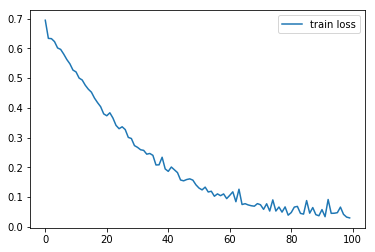

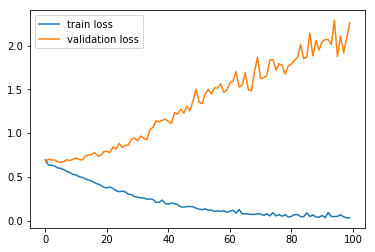

In [111]:
import matplotlib.pyplot as plt
% matplotlib inline
# Without regularization
n_epochs = 100
trainloss, = plt.plot(np.arange(n_epochs), clf.log.losses, label='train loss')
plt.legend(handles=[trainloss])
plt.show()
trainloss, = plt.plot(np.arange(n_epochs), clf.log.losses, label='train loss')
valloss, = plt.plot(np.arange(n_epochs), clf.log.val_losses, label='validation loss')
plt.legend(handles=[trainloss, valloss])
plt.show()

In [112]:
clf_reg = CnnLstmClassifier(n_lstm=2, n_filters=2)
clf_reg.train(X_train, y_train, X_val, y_val, n_epochs=100, l1=0.0001, l2=0.0001, dropout=0.5, dropout_lstm=0.5, recurrent_dropout=0.5)

Training began


Train on 464 samples, validate on 117 samples
Epoch 1/100
464/464 [==============================] - 8s 17ms/step - loss: 0.7072 - acc: 0.5862 - val_loss: 0.6879 - val_acc: 0.5726


epoch 1 results: train loss = 0.707173, val loss = 0.687929
			acc = 0.586207, val acc = 0.572650
			auc = 0.548571


Epoch 2/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6956 - acc: 0.6164 - val_loss: 0.6899 - val_acc: 0.5726


epoch 2 results: train loss = 0.695631, val loss = 0.689922
			acc = 0.616379, val acc = 0.572650
			auc = 0.513016


Epoch 3/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6870 - acc: 0.6272 - val_loss: 0.6781 - val_acc: 0.5983


epoch 3 results: train loss = 0.687033, val loss = 0.678139
			acc = 0.627155, val acc = 0.598291
			auc = 0.579048


Epoch 4/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6833 - acc: 0.6164 - val_loss: 0.6766 - val_acc: 0.6325


epoch 4 results: train loss = 0.683294, val loss = 0.676601
			acc = 0.616379, val acc = 0.632479
			auc = 0.543175


Epoch 5/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6690 - acc: 0.6422 - val_loss: 0.6730 - val_acc: 0.6154


epoch 5 results: train loss = 0.669007, val loss = 0.673001
			acc = 0.642241, val acc = 0.615385
			auc = 0.554444


Epoch 6/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6727 - acc: 0.6250 - val_loss: 0.6694 - val_acc: 0.6496


epoch 6 results: train loss = 0.672670, val loss = 0.669424
			acc = 0.625000, val acc = 0.649573
			auc = 0.550476


Epoch 7/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6852 - acc: 0.6078 - val_loss: 0.6699 - val_acc: 0.6410


epoch 7 results: train loss = 0.685240, val loss = 0.669861
			acc = 0.607759, val acc = 0.641026
			auc = 0.525238


Epoch 8/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6662 - acc: 0.6293 - val_loss: 0.6699 - val_acc: 0.6410


epoch 8 results: train loss = 0.666154, val loss = 0.669933
			acc = 0.629310, val acc = 0.641026
			auc = 0.512381


Epoch 9/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6637 - acc: 0.6315 - val_loss: 0.6702 - val_acc: 0.6410


epoch 9 results: train loss = 0.663651, val loss = 0.670235
			acc = 0.631466, val acc = 0.641026
			auc = 0.502381


Epoch 10/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6653 - acc: 0.6315 - val_loss: 0.6692 - val_acc: 0.6410


epoch 10 results: train loss = 0.665340, val loss = 0.669190
			acc = 0.631466, val acc = 0.641026
			auc = 0.494444


Epoch 11/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6622 - acc: 0.6293 - val_loss: 0.6712 - val_acc: 0.6410


epoch 11 results: train loss = 0.662187, val loss = 0.671197
			acc = 0.629310, val acc = 0.641026
			auc = 0.486349


Epoch 12/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6611 - acc: 0.6358 - val_loss: 0.6664 - val_acc: 0.6410


epoch 12 results: train loss = 0.661120, val loss = 0.666440
			acc = 0.635776, val acc = 0.641026
			auc = 0.505079


Epoch 13/100
464/464 [==============================] - 3s 5ms/step - loss: 0.6629 - acc: 0.6142 - val_loss: 0.6665 - val_acc: 0.6410


epoch 13 results: train loss = 0.662946, val loss = 0.666472
			acc = 0.614224, val acc = 0.641026
			auc = 0.502381


Epoch 14/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6556 - acc: 0.6379 - val_loss: 0.6666 - val_acc: 0.6410


epoch 14 results: train loss = 0.655573, val loss = 0.666585
			acc = 0.637931, val acc = 0.641026
			auc = 0.486984


Epoch 15/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6659 - acc: 0.6250 - val_loss: 0.6710 - val_acc: 0.6410


epoch 15 results: train loss = 0.665871, val loss = 0.670958
			acc = 0.625000, val acc = 0.641026
			auc = 0.448730


Epoch 16/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6631 - acc: 0.6336 - val_loss: 0.6643 - val_acc: 0.6410


epoch 16 results: train loss = 0.663105, val loss = 0.664319
			acc = 0.633621, val acc = 0.641026
			auc = 0.511905


Epoch 17/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6555 - acc: 0.6466 - val_loss: 0.6657 - val_acc: 0.6410


epoch 17 results: train loss = 0.655505, val loss = 0.665723
			acc = 0.646552, val acc = 0.641026
			auc = 0.495238


Epoch 18/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6687 - acc: 0.6272 - val_loss: 0.6616 - val_acc: 0.6410


epoch 18 results: train loss = 0.668741, val loss = 0.661580
			acc = 0.627155, val acc = 0.641026
			auc = 0.507937


Epoch 19/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6630 - acc: 0.6336 - val_loss: 0.6627 - val_acc: 0.6410


epoch 19 results: train loss = 0.663018, val loss = 0.662658
			acc = 0.633621, val acc = 0.641026
			auc = 0.506190


Epoch 20/100
464/464 [==============================] - ETA: 0s - loss: 0.6626 - acc: 0.637 - 2s 5ms/step - loss: 0.6621 - acc: 0.6379 - val_loss: 0.6637 - val_acc: 0.6410


epoch 20 results: train loss = 0.662111, val loss = 0.663665
			acc = 0.637931, val acc = 0.641026
			auc = 0.496349


Epoch 21/100
464/464 [==============================] - 3s 6ms/step - loss: 0.6631 - acc: 0.6336 - val_loss: 0.6665 - val_acc: 0.6410


epoch 21 results: train loss = 0.663077, val loss = 0.666452
			acc = 0.633621, val acc = 0.641026
			auc = 0.472540


Epoch 22/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6551 - acc: 0.6552 - val_loss: 0.6672 - val_acc: 0.6410


epoch 22 results: train loss = 0.655071, val loss = 0.667201
			acc = 0.655172, val acc = 0.641026
			auc = 0.474127


Epoch 23/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6521 - acc: 0.6530 - val_loss: 0.6625 - val_acc: 0.6410


epoch 23 results: train loss = 0.652089, val loss = 0.662489
			acc = 0.653017, val acc = 0.641026
			auc = 0.496508


Epoch 24/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6596 - acc: 0.6315 - val_loss: 0.6600 - val_acc: 0.6410


epoch 24 results: train loss = 0.659603, val loss = 0.659957
			acc = 0.631466, val acc = 0.641026
			auc = 0.510476


Epoch 25/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6474 - acc: 0.6509 - val_loss: 0.6608 - val_acc: 0.6410


epoch 25 results: train loss = 0.647361, val loss = 0.660770
			acc = 0.650862, val acc = 0.641026
			auc = 0.494921


Epoch 26/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6569 - acc: 0.6379 - val_loss: 0.6589 - val_acc: 0.6410


epoch 26 results: train loss = 0.656937, val loss = 0.658910
			acc = 0.637931, val acc = 0.641026
			auc = 0.515556


Epoch 27/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6482 - acc: 0.6444 - val_loss: 0.6592 - val_acc: 0.6410


epoch 27 results: train loss = 0.648174, val loss = 0.659198
			acc = 0.644397, val acc = 0.641026
			auc = 0.507302


Epoch 28/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6529 - acc: 0.6401 - val_loss: 0.6632 - val_acc: 0.6410


epoch 28 results: train loss = 0.652946, val loss = 0.663225
			acc = 0.640086, val acc = 0.641026
			auc = 0.492222


Epoch 29/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6689 - acc: 0.6164 - val_loss: 0.6609 - val_acc: 0.6410


epoch 29 results: train loss = 0.668886, val loss = 0.660903
			acc = 0.616379, val acc = 0.641026
			auc = 0.511111


Epoch 30/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6570 - acc: 0.6444 - val_loss: 0.6618 - val_acc: 0.6410


epoch 30 results: train loss = 0.657041, val loss = 0.661842
			acc = 0.644397, val acc = 0.641026
			auc = 0.510476


Epoch 31/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6584 - acc: 0.6293 - val_loss: 0.6630 - val_acc: 0.6410


epoch 31 results: train loss = 0.658431, val loss = 0.663031
			acc = 0.629310, val acc = 0.641026
			auc = 0.480635


Epoch 32/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6557 - acc: 0.6336 - val_loss: 0.6593 - val_acc: 0.6410


epoch 32 results: train loss = 0.655680, val loss = 0.659268
			acc = 0.633621, val acc = 0.641026
			auc = 0.496508


Epoch 33/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6534 - acc: 0.6336 - val_loss: 0.6580 - val_acc: 0.6410


epoch 33 results: train loss = 0.653406, val loss = 0.658018
			acc = 0.633621, val acc = 0.641026
			auc = 0.522540


Epoch 34/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6657 - acc: 0.6250 - val_loss: 0.6591 - val_acc: 0.6410


epoch 34 results: train loss = 0.665737, val loss = 0.659066
			acc = 0.625000, val acc = 0.641026
			auc = 0.511746


Epoch 35/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6623 - acc: 0.6401 - val_loss: 0.6606 - val_acc: 0.6410


epoch 35 results: train loss = 0.662307, val loss = 0.660632
			acc = 0.640086, val acc = 0.641026
			auc = 0.482540


Epoch 36/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6489 - acc: 0.6422 - val_loss: 0.6593 - val_acc: 0.6410


epoch 36 results: train loss = 0.648918, val loss = 0.659270
			acc = 0.642241, val acc = 0.641026
			auc = 0.515556


Epoch 37/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6599 - acc: 0.6358 - val_loss: 0.6572 - val_acc: 0.6410


epoch 37 results: train loss = 0.659940, val loss = 0.657183
			acc = 0.635776, val acc = 0.641026
			auc = 0.512857


Epoch 38/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6567 - acc: 0.6487 - val_loss: 0.6583 - val_acc: 0.6410


epoch 38 results: train loss = 0.656659, val loss = 0.658343
			acc = 0.648707, val acc = 0.641026
			auc = 0.500317


Epoch 39/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6567 - acc: 0.6358 - val_loss: 0.6565 - val_acc: 0.6410


epoch 39 results: train loss = 0.656724, val loss = 0.656544
			acc = 0.635776, val acc = 0.641026
			auc = 0.522540


Epoch 40/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6567 - acc: 0.6250 - val_loss: 0.6582 - val_acc: 0.6410


epoch 40 results: train loss = 0.656724, val loss = 0.658235
			acc = 0.625000, val acc = 0.641026
			auc = 0.518730


Epoch 41/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6450 - acc: 0.6530 - val_loss: 0.6576 - val_acc: 0.6410


epoch 41 results: train loss = 0.645017, val loss = 0.657550
			acc = 0.653017, val acc = 0.641026
			auc = 0.508889


Epoch 42/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6639 - acc: 0.6228 - val_loss: 0.6596 - val_acc: 0.6410


epoch 42 results: train loss = 0.663859, val loss = 0.659604
			acc = 0.622845, val acc = 0.641026
			auc = 0.493333


Epoch 43/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6466 - acc: 0.6401 - val_loss: 0.6543 - val_acc: 0.6410


epoch 43 results: train loss = 0.646599, val loss = 0.654265
			acc = 0.640086, val acc = 0.641026
			auc = 0.516190


Epoch 44/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6609 - acc: 0.6358 - val_loss: 0.6551 - val_acc: 0.6410


epoch 44 results: train loss = 0.660856, val loss = 0.655147
			acc = 0.635776, val acc = 0.641026
			auc = 0.551270


Epoch 45/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6559 - acc: 0.6379 - val_loss: 0.6538 - val_acc: 0.6410


epoch 45 results: train loss = 0.655932, val loss = 0.653817
			acc = 0.637931, val acc = 0.641026
			auc = 0.538889


Epoch 46/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6601 - acc: 0.6401 - val_loss: 0.6534 - val_acc: 0.6410


epoch 46 results: train loss = 0.660112, val loss = 0.653361
			acc = 0.640086, val acc = 0.641026
			auc = 0.550000


Epoch 47/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6569 - acc: 0.6336 - val_loss: 0.6602 - val_acc: 0.6410


epoch 47 results: train loss = 0.656891, val loss = 0.660191
			acc = 0.633621, val acc = 0.641026
			auc = 0.506508


Epoch 48/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6550 - acc: 0.6444 - val_loss: 0.6537 - val_acc: 0.6410


epoch 48 results: train loss = 0.654978, val loss = 0.653688
			acc = 0.644397, val acc = 0.641026
			auc = 0.551111


Epoch 49/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6504 - acc: 0.6422 - val_loss: 0.6558 - val_acc: 0.6410


epoch 49 results: train loss = 0.650445, val loss = 0.655766
			acc = 0.642241, val acc = 0.641026
			auc = 0.516508


Epoch 50/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6517 - acc: 0.6358 - val_loss: 0.6584 - val_acc: 0.6410


epoch 50 results: train loss = 0.651715, val loss = 0.658358
			acc = 0.635776, val acc = 0.641026
			auc = 0.519365


Epoch 51/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6589 - acc: 0.6250 - val_loss: 0.6490 - val_acc: 0.6410


epoch 51 results: train loss = 0.658865, val loss = 0.649032
			acc = 0.625000, val acc = 0.641026
			auc = 0.568095


Epoch 52/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6562 - acc: 0.6315 - val_loss: 0.6584 - val_acc: 0.6410


epoch 52 results: train loss = 0.656236, val loss = 0.658432
			acc = 0.631466, val acc = 0.641026
			auc = 0.535556


Epoch 53/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6472 - acc: 0.6487 - val_loss: 0.6635 - val_acc: 0.6410


epoch 53 results: train loss = 0.647202, val loss = 0.663508
			acc = 0.648707, val acc = 0.641026
			auc = 0.467778


Epoch 54/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6542 - acc: 0.6336 - val_loss: 0.6605 - val_acc: 0.6410


epoch 54 results: train loss = 0.654226, val loss = 0.660497
			acc = 0.633621, val acc = 0.641026
			auc = 0.488730


Epoch 55/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6492 - acc: 0.6379 - val_loss: 0.6610 - val_acc: 0.6410


epoch 55 results: train loss = 0.649182, val loss = 0.660965
			acc = 0.637931, val acc = 0.641026
			auc = 0.495556


Epoch 56/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6583 - acc: 0.6272 - val_loss: 0.6550 - val_acc: 0.6410


epoch 56 results: train loss = 0.658327, val loss = 0.655028
			acc = 0.627155, val acc = 0.641026
			auc = 0.546825


Epoch 57/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6571 - acc: 0.6336 - val_loss: 0.6538 - val_acc: 0.6410


epoch 57 results: train loss = 0.657092, val loss = 0.653819
			acc = 0.633621, val acc = 0.641026
			auc = 0.570794


Epoch 58/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6522 - acc: 0.6379 - val_loss: 0.6630 - val_acc: 0.6410


epoch 58 results: train loss = 0.652246, val loss = 0.662985
			acc = 0.637931, val acc = 0.641026
			auc = 0.483016


Epoch 59/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6539 - acc: 0.6358 - val_loss: 0.6581 - val_acc: 0.6410


epoch 59 results: train loss = 0.653899, val loss = 0.658060
			acc = 0.635776, val acc = 0.641026
			auc = 0.529365


Epoch 60/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6554 - acc: 0.6358 - val_loss: 0.6606 - val_acc: 0.6410


epoch 60 results: train loss = 0.655405, val loss = 0.660611
			acc = 0.635776, val acc = 0.641026
			auc = 0.498413


Epoch 61/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6558 - acc: 0.6444 - val_loss: 0.6630 - val_acc: 0.6410


epoch 61 results: train loss = 0.655848, val loss = 0.662984
			acc = 0.644397, val acc = 0.641026
			auc = 0.481429


Epoch 62/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6514 - acc: 0.6379 - val_loss: 0.6605 - val_acc: 0.6410


epoch 62 results: train loss = 0.651356, val loss = 0.660511
			acc = 0.637931, val acc = 0.641026
			auc = 0.498730


Epoch 63/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6562 - acc: 0.6336 - val_loss: 0.6604 - val_acc: 0.6410


epoch 63 results: train loss = 0.656219, val loss = 0.660403
			acc = 0.633621, val acc = 0.641026
			auc = 0.507143


Epoch 64/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6574 - acc: 0.6422 - val_loss: 0.6623 - val_acc: 0.6410


epoch 64 results: train loss = 0.657375, val loss = 0.662333
			acc = 0.642241, val acc = 0.641026
			auc = 0.512381


Epoch 65/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6510 - acc: 0.6401 - val_loss: 0.6607 - val_acc: 0.6410


epoch 65 results: train loss = 0.650958, val loss = 0.660704
			acc = 0.640086, val acc = 0.641026
			auc = 0.516190


Epoch 66/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6612 - acc: 0.6422 - val_loss: 0.6613 - val_acc: 0.6410


epoch 66 results: train loss = 0.661168, val loss = 0.661298
			acc = 0.642241, val acc = 0.641026
			auc = 0.509841


Epoch 67/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6520 - acc: 0.6466 - val_loss: 0.6561 - val_acc: 0.6410


epoch 67 results: train loss = 0.651987, val loss = 0.656127
			acc = 0.646552, val acc = 0.641026
			auc = 0.514286


Epoch 68/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6508 - acc: 0.6379 - val_loss: 0.6612 - val_acc: 0.6410


epoch 68 results: train loss = 0.650812, val loss = 0.661198
			acc = 0.637931, val acc = 0.641026
			auc = 0.508889


Epoch 69/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6605 - acc: 0.6358 - val_loss: 0.6539 - val_acc: 0.6410


epoch 69 results: train loss = 0.660512, val loss = 0.653940
			acc = 0.635776, val acc = 0.641026
			auc = 0.533968


Epoch 70/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6491 - acc: 0.6422 - val_loss: 0.6550 - val_acc: 0.6410


epoch 70 results: train loss = 0.649072, val loss = 0.655049
			acc = 0.642241, val acc = 0.641026
			auc = 0.504286


Epoch 71/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6565 - acc: 0.6315 - val_loss: 0.6580 - val_acc: 0.6410


epoch 71 results: train loss = 0.656547, val loss = 0.657973
			acc = 0.631466, val acc = 0.641026
			auc = 0.501270


Epoch 72/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6539 - acc: 0.6401 - val_loss: 0.6571 - val_acc: 0.6410


epoch 72 results: train loss = 0.653871, val loss = 0.657130
			acc = 0.640086, val acc = 0.641026
			auc = 0.501587


Epoch 73/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6501 - acc: 0.6379 - val_loss: 0.6543 - val_acc: 0.6410


epoch 73 results: train loss = 0.650076, val loss = 0.654307
			acc = 0.637931, val acc = 0.641026
			auc = 0.537460


Epoch 74/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6540 - acc: 0.6401 - val_loss: 0.6541 - val_acc: 0.6410


epoch 74 results: train loss = 0.654041, val loss = 0.654098
			acc = 0.640086, val acc = 0.641026
			auc = 0.530159


Epoch 75/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6543 - acc: 0.6379 - val_loss: 0.6543 - val_acc: 0.6410


epoch 75 results: train loss = 0.654276, val loss = 0.654254
			acc = 0.637931, val acc = 0.641026
			auc = 0.524603


Epoch 76/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6476 - acc: 0.6466 - val_loss: 0.6572 - val_acc: 0.6410


epoch 76 results: train loss = 0.647600, val loss = 0.657175
			acc = 0.646552, val acc = 0.641026
			auc = 0.494762


Epoch 77/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6516 - acc: 0.6358 - val_loss: 0.6588 - val_acc: 0.6410


epoch 77 results: train loss = 0.651593, val loss = 0.658802
			acc = 0.635776, val acc = 0.641026
			auc = 0.496190


Epoch 78/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6516 - acc: 0.6401 - val_loss: 0.6550 - val_acc: 0.6410


epoch 78 results: train loss = 0.651643, val loss = 0.655004
			acc = 0.640086, val acc = 0.641026
			auc = 0.507937


Epoch 79/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6524 - acc: 0.6466 - val_loss: 0.6523 - val_acc: 0.6410


epoch 79 results: train loss = 0.652367, val loss = 0.652278
			acc = 0.646552, val acc = 0.641026
			auc = 0.535079


Epoch 80/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6496 - acc: 0.6466 - val_loss: 0.6564 - val_acc: 0.6410


epoch 80 results: train loss = 0.649644, val loss = 0.656383
			acc = 0.646552, val acc = 0.641026
			auc = 0.512857


Epoch 81/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6479 - acc: 0.6466 - val_loss: 0.6504 - val_acc: 0.6410


epoch 81 results: train loss = 0.647862, val loss = 0.650419
			acc = 0.646552, val acc = 0.641026
			auc = 0.544921


Epoch 82/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6530 - acc: 0.6422 - val_loss: 0.6612 - val_acc: 0.6410


epoch 82 results: train loss = 0.652963, val loss = 0.661238
			acc = 0.642241, val acc = 0.641026
			auc = 0.496508


Epoch 83/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6570 - acc: 0.6336 - val_loss: 0.6528 - val_acc: 0.6410


epoch 83 results: train loss = 0.657007, val loss = 0.652822
			acc = 0.633621, val acc = 0.641026
			auc = 0.518095


Epoch 84/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6522 - acc: 0.6336 - val_loss: 0.6507 - val_acc: 0.6410


epoch 84 results: train loss = 0.652249, val loss = 0.650689
			acc = 0.633621, val acc = 0.641026
			auc = 0.538413


Epoch 85/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6458 - acc: 0.6358 - val_loss: 0.6533 - val_acc: 0.6410


epoch 85 results: train loss = 0.645799, val loss = 0.653346
			acc = 0.635776, val acc = 0.641026
			auc = 0.538254


Epoch 86/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6579 - acc: 0.6336 - val_loss: 0.6634 - val_acc: 0.6410


epoch 86 results: train loss = 0.657869, val loss = 0.663387
			acc = 0.633621, val acc = 0.641026
			auc = 0.488571


Epoch 87/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6545 - acc: 0.6336 - val_loss: 0.6622 - val_acc: 0.6410


epoch 87 results: train loss = 0.654489, val loss = 0.662175
			acc = 0.633621, val acc = 0.641026
			auc = 0.489524


Epoch 88/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6498 - acc: 0.6293 - val_loss: 0.6602 - val_acc: 0.6410


epoch 88 results: train loss = 0.649785, val loss = 0.660156
			acc = 0.629310, val acc = 0.641026
			auc = 0.492698


Epoch 89/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6475 - acc: 0.6444 - val_loss: 0.6679 - val_acc: 0.6410


epoch 89 results: train loss = 0.647523, val loss = 0.667935
			acc = 0.644397, val acc = 0.641026
			auc = 0.478730


Epoch 90/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6492 - acc: 0.6336 - val_loss: 0.6619 - val_acc: 0.6410


epoch 90 results: train loss = 0.649240, val loss = 0.661904
			acc = 0.633621, val acc = 0.641026
			auc = 0.510317


Epoch 91/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6468 - acc: 0.6358 - val_loss: 0.6594 - val_acc: 0.6410


epoch 91 results: train loss = 0.646822, val loss = 0.659440
			acc = 0.635776, val acc = 0.641026
			auc = 0.510635


Epoch 92/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6430 - acc: 0.6466 - val_loss: 0.6595 - val_acc: 0.6410


epoch 92 results: train loss = 0.642969, val loss = 0.659494
			acc = 0.646552, val acc = 0.641026
			auc = 0.515873


Epoch 93/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6486 - acc: 0.6509 - val_loss: 0.6673 - val_acc: 0.6410


epoch 93 results: train loss = 0.648554, val loss = 0.667316
			acc = 0.650862, val acc = 0.641026
			auc = 0.433333


Epoch 94/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6480 - acc: 0.6422 - val_loss: 0.6693 - val_acc: 0.6410


epoch 94 results: train loss = 0.648037, val loss = 0.669296
			acc = 0.642241, val acc = 0.641026
			auc = 0.452540


Epoch 95/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6509 - acc: 0.6444 - val_loss: 0.6530 - val_acc: 0.6410


epoch 95 results: train loss = 0.650920, val loss = 0.653027
			acc = 0.644397, val acc = 0.641026
			auc = 0.544603


Epoch 96/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6546 - acc: 0.6272 - val_loss: 0.6583 - val_acc: 0.6410


epoch 96 results: train loss = 0.654561, val loss = 0.658295
			acc = 0.627155, val acc = 0.641026
			auc = 0.510635


Epoch 97/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6520 - acc: 0.6444 - val_loss: 0.6573 - val_acc: 0.6410


epoch 97 results: train loss = 0.652050, val loss = 0.657335
			acc = 0.644397, val acc = 0.641026
			auc = 0.494127


Epoch 98/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6508 - acc: 0.6422 - val_loss: 0.6573 - val_acc: 0.6410


epoch 98 results: train loss = 0.650806, val loss = 0.657273
			acc = 0.642241, val acc = 0.641026
			auc = 0.504127


Epoch 99/100
464/464 [==============================] - 2s 4ms/step - loss: 0.6486 - acc: 0.6509 - val_loss: 0.6538 - val_acc: 0.6410


epoch 99 results: train loss = 0.648618, val loss = 0.653808
			acc = 0.650862, val acc = 0.641026
			auc = 0.525873


Epoch 100/100
464/464 [==============================] - 2s 5ms/step - loss: 0.6539 - acc: 0.6379 - val_loss: 0.6587 - val_acc: 0.6410


epoch 100 results: train loss = 0.653897, val loss = 0.658699
			acc = 0.637931, val acc = 0.641026
			auc = 0.519365


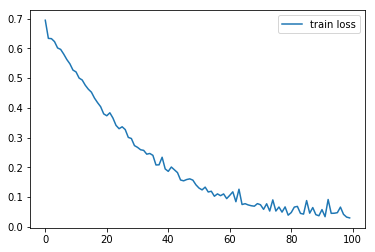

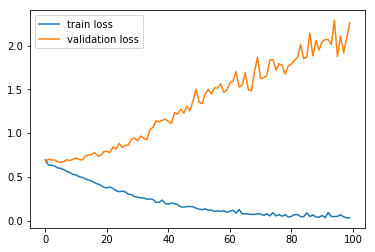

In [113]:
# With regularization and dropout
n_epochs = 100
trainloss, = plt.plot(np.arange(n_epochs), clf.log.losses, label='train loss')
plt.legend(handles=[trainloss])
plt.show()
trainloss, = plt.plot(np.arange(n_epochs), clf.log.losses, label='train loss')
valloss, = plt.plot(np.arange(n_epochs), clf.log.val_losses, label='validation loss')
plt.legend(handles=[trainloss, valloss])
plt.show()

## Hyperparameter tuning

In [ ]:
learning_rate = 0.001


In [ ]:
clf = CnnLstmClassifier(n_lstm=30, n_filters=10)
clf.train(X_train, y_train, X_val, y_val, n_epochs=100)